In [68]:
import tensorflow as tf
import yfinance as yf
import pandas as pd
import numpy as np
print(tf.__version__)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

2.19.0


##Day 1: The Basics

In [69]:
# 0-D tensor (scalar)
scalar = tf.constant(5)
print(scalar)

# 1-D tensor (vector)
vector = tf.constant([1, 2, 3])
print(vector)

# 2-D tensor (matrix)
matrix = tf.constant([[1, 2], [3, 4]])
print(matrix)

# 3-D tensor
tensor3d = tf.constant([[[1], [2]], [[3], [4]]])
print(tensor3d)

tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor([1 2 3], shape=(3,), dtype=int32)
tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[[1]
  [2]]

 [[3]
  [4]]], shape=(2, 2, 1), dtype=int32)


In [70]:
matrix = tf.constant(tf.range(1,10), shape=(3,3))
matrix

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]], dtype=int32)>

In [71]:
mat1 = tf.constant([[1, 2], [3, 4]])
mat2 = tf.constant([[5, 6], [7, 8]])

In [72]:
print(mat1 + mat2)
print(mat1 - mat2)
print(mat1 * mat2)
print(mat1 / mat2)

tf.Tensor(
[[ 6  8]
 [10 12]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[-4 -4]
 [-4 -4]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[ 5 12]
 [21 32]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[0.2        0.33333333]
 [0.42857143 0.5       ]], shape=(2, 2), dtype=float64)


In [73]:
print(tf.matmul(mat1, mat2))

tf.Tensor(
[[19 22]
 [43 50]], shape=(2, 2), dtype=int32)


In [74]:
print(tf.reduce_sum(mat1))
print(tf.reduce_mean(mat1))

tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)


In [75]:
transosed=tf.transpose(mat1)
transosed

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 3],
       [2, 4]], dtype=int32)>

In [76]:
x=tf.constant([1.0,4.0,9.0,16.0])
print(tf.sqrt(x))
print(tf.exp(x))
tensor = tf.constant([[1.0, 2, 3], [4, 5, 6]])
total_sum=tf.reduce_sum(tensor)
print(total_sum)
mean_value=tf.reduce_mean(tensor)
print(mean_value)
tensor= tf.constant([[1, 2],[3,4]], dtype=tf.float32)
print(tf.sqrt(tf.reduce_sum(tf.square(tensor))))

tf.Tensor([1. 2. 3. 4.], shape=(4,), dtype=float32)
tf.Tensor([2.7182817e+00 5.4598148e+01 8.1030840e+03 8.8861110e+06], shape=(4,), dtype=float32)
tf.Tensor(21.0, shape=(), dtype=float32)
tf.Tensor(3.5, shape=(), dtype=float32)
tf.Tensor(5.477226, shape=(), dtype=float32)


##Day 2: Building Blocks for Time Series Modeling

In [77]:
data = yf.download("AAPL", start="2023-01-01", end="2023-07-01",auto_adjust=False)
data.columns = data.columns.droplevel(1)
features= data[['Open', 'Close', 'Volume']]
# Convert to float32 tensor
features = tf.constant(features.values, dtype=tf.float32)
dta=data

[*********************100%***********************]  1 of 1 completed


In [78]:
# Min-max normalization
min_val = tf.reduce_min(features, axis=0)
max_val = tf.reduce_max(features, axis=0)
normalized_features = (features - min_val) / (max_val - min_val)
print(normalized_features[:5])

tf.Tensor(
[[0.06507157 0.00072521 0.63925546]
 [0.0134105  0.01943443 0.44279304]
 [0.01706789 0.         0.37318116]
 [0.         0.06671499 0.43118754]
 [0.06796706 0.0744017  0.2863091 ]], shape=(5, 3), dtype=float32)


In [79]:
sequence_length=5
X=[]
Y=[]
for i in range(len(normalized_features)-sequence_length):
  X.append(normalized_features[i:i+sequence_length])
  Y.append(normalized_features[i+sequence_length,1])

X=tf.stack(X)
Y=tf.stack(Y)
print(X.shape, Y.shape)

(119, 5, 3) (119,)


In [80]:
data=tf.data.Dataset.from_tensor_slices((X,Y))

In [81]:
for seq, label in data.take(2):
    print("Sequence:", seq.numpy())
    print("Label:", label.numpy())

Sequence: [[0.06507157 0.00072521 0.63925546]
 [0.0134105  0.01943443 0.44279304]
 [0.01706789 0.         0.37318116]
 [0.         0.06671499 0.43118754]
 [0.06796706 0.0744017  0.2863091 ]]
Label: 0.08281361
Sequence: [[0.0134105  0.01943443 0.44279304]
 [0.01706789 0.         0.37318116]
 [0.         0.06671499 0.43118754]
 [0.06796706 0.0744017  0.2863091 ]
 [0.06476672 0.08281361 0.22742647]]
Label: 0.12284276


In [82]:
data = data.shuffle(buffer_size=100)  # buffer_size >= dataset size is best
batch_size= 16
data=data.batch(batch_size)

In [83]:
# Lets TensorFlow prepare the next batch while training on the current batch, speeding up training.
data=data.prefetch(tf.data.AUTOTUNE)

In [84]:
returns = (features[:, 1] - features[:, 0]) / features[:, 0]
returns = tf.expand_dims(returns, 1)
features_with_returns = tf.concat([features, returns], axis=1)

In [85]:
# 3-day ma of close price
close_prices= normalized_features[:,1]
ma3 = tf.concat([tf.zeros(2), tf.reduce_mean(tf.stack([close_prices[i-2:i+1] for i in range(2, len(close_prices))]), axis=1)], axis=0)
ma3 = tf.expand_dims(ma3, axis=1)
features_with_ma = tf.concat([features_with_returns, ma3], axis=1)

In [86]:
sequence_length = 5
horizon = 3  # predict next 3 days

X = []
Y = []
for i in range(len(features_with_ma) - sequence_length - horizon + 1):
  X.append(features_with_ma[i:i+sequence_length])
  Y.append(features_with_ma[i+sequence_length:i+sequence_length+horizon,1])

X = tf.stack(X)
Y = tf.stack(Y)

In [87]:
#split code into training and test datasets
split= .8*len(X)
print(split)
X_train, X_test = X[:int(split)], X[int(split):]
Y_train, Y_test = Y[:int(split)], Y[int(split):]
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(100).batch(16).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(16).prefetch(tf.data.AUTOTUNE)

93.60000000000001


## Day 3: Training LSTM Model in TensorFlow

In [88]:
X_dummy = np.random.rand(100, 5, 3).astype(np.float32)
y_dummy = np.random.rand(100, 1).astype(np.float32)
model = Sequential([
    LSTM(units=32, input_shape=(5, 3)),   # 32 memory units, 5 timesteps, 3 features
    Dense(1)                              # output layer (predict 1 value, e.g., next Close)
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [89]:
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 32)             │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,641 (18.13 KB)

 Trainable params: 4,641 (18.13 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
model = Sequential([
    LSTM(units=64, return_sequences=False, input_shape=(sequence_length, X_train.shape[2])),
    Dropout(0.2),   # helps prevent overfitting - randomly turns off 20% of neurons each batch → avoids overfitting.
    Dense(32, activation='relu'),
    Dense(1)        # predict next-day Close (or horizon if multi-step)
])


In [91]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']   # mean absolute error for interpretability
)

In [92]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 24391.6875 - mae: 155.8196 - val_loss: 33175.9336 - val_mae: 182.0867
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24980.2402 - mae: 157.6960 - val_loss: 33027.1406 - val_mae: 181.6777
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24467.8848 - mae: 156.0198 - val_loss: 32859.9648 - val_mae: 181.2170
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24393.4277 - mae: 155.7842 - val_loss: 32668.8340 - val_mae: 180.6889
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24125.8438 - mae: 154.9416 - val_loss: 32462.2500 - val_mae: 180.1163
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23769.5762 - mae: 153.7571 - val_loss: 32235.6270 - val_mae: 179.4861
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23849.0312 - mae: 154.0628 - val_loss: 31988.5801 - val_mae: 178.7966
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23725.7051 - mae: 153.5992 - val_loss: 31732.6719 - val_mae: 

In [93]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,101 (234.77 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,068 (156.52 KB)

Now we make predictions on the dataset:

In [94]:
# Predict on test dataset
y_pred = model.predict(test_dataset)

# If your y_test is batched, you may need to flatten it
y_true = np.concatenate([y for x, y in test_dataset], axis=0)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


In [95]:
# Assuming Close price was the second feature (index 1)
close_min = tf.reduce_min(dta['Close'].values)
close_max = tf.reduce_max(dta['Close'].values)

y_pred_rescaled = y_pred * (close_max - close_min) + close_min
y_true_rescaled = y_true * (close_max - close_min) + close_min


#Putting it all together:

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.2860 - mae: 0.4940 - val_loss: 0.4277 - val_mae: 0.6515
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1205 - mae: 0.3141 - val_loss: 0.1483 - val_mae: 0.3822
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0232 - mae: 0.1273 - val_loss: 0.0082 - val_mae: 0.0816
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0102 - mae: 0.0846 - val_loss: 0.0041 - val_mae: 0.0525
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0142 - mae: 0.1022 - val_loss: 0.0053 - val_mae: 0.0644
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0048 - mae: 0.0574 - val_loss: 0.0294 - val_mae: 0.1674
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0067 - mae: 0.0682 - val_loss: 0.0277 - val_mae: 0.1628
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0044 - mae: 0.0544 - val_loss: 0.0121 - val_mae: 0.1053
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - mae: 0.0474 - 

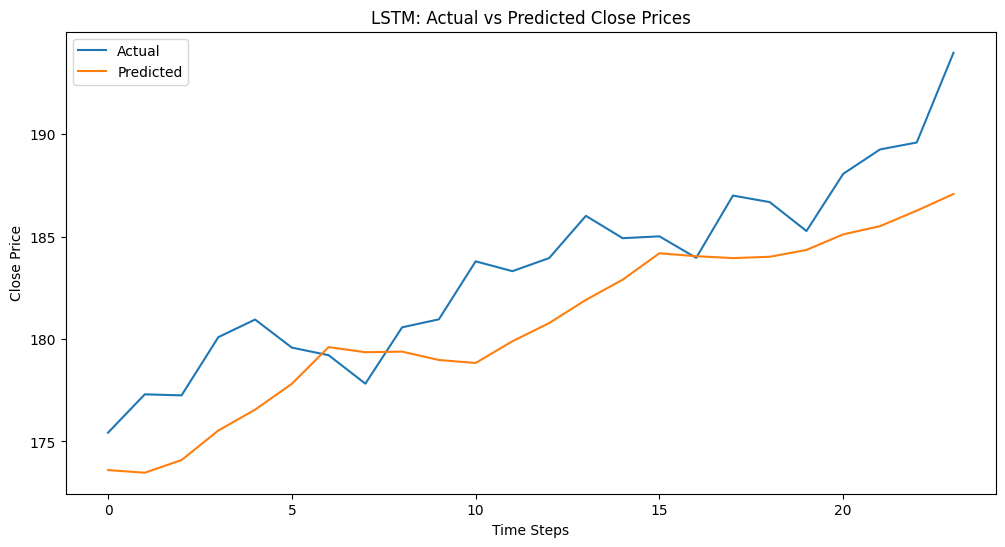

MSE: 10.2335, MAE: 2.7823


In [99]:
# ================================================
# Complete LSTM pipeline using NumPy arrays for prediction
# ================================================

import yfinance as yf
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ------------------------------
# 1️⃣ Download historical stock data
# ------------------------------
data = yf.download("AAPL", start="2025-01-01", end="2025-09-01",auto_adjust=False)
data.columns = data.columns.droplevel(1)
# Use Open, Close, Volume as features
features = data[['Open', 'Close', 'Volume']].values.astype(np.float32)

# ------------------------------
# 2️⃣ Normalize features
# ------------------------------
min_vals = features.min(axis=0)
max_vals = features.max(axis=0)
normalized_features = (features - min_vals) / (max_vals - min_vals)

# ------------------------------
# 3️⃣ Create sequences (sliding window)
# ------------------------------
sequence_length = 5
X = []
y = []

for i in range(len(normalized_features) - sequence_length):
    X.append(normalized_features[i:i+sequence_length])
    y.append(normalized_features[i+sequence_length, 1])  # predict next-day Close

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

# ------------------------------
# 4️⃣ Train/Test split
# ------------------------------
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ------------------------------
# 5️⃣ Build LSTM model
# ------------------------------
model = Sequential([
    LSTM(64, input_shape=(sequence_length, X_train.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse', metrics=['mae'])
model.summary()

# ------------------------------
# 6️⃣ Train model
# ------------------------------
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16)

# ------------------------------
# 7️⃣ Predict directly on X_test
# ------------------------------
y_pred = model.predict(X_test).flatten()  # flatten to 1D
y_true = y_test  # already 1D

# ------------------------------
# 8️⃣ Rescale predictions to original price
# ------------------------------
close_min = data['Close'].min()
close_max = data['Close'].max()

y_pred_rescaled = y_pred * (close_max - close_min) + close_min
y_true_rescaled = y_true * (close_max - close_min) + close_min

# ------------------------------
# 9️⃣ Plot Actual vs Predicted
# ------------------------------
plt.figure(figsize=(12,6))
plt.plot(y_true_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.xlabel("Time Steps")
plt.ylabel("Close Price")
plt.title("LSTM: Actual vs Predicted Close Prices")
plt.legend()
plt.show()

# ------------------------------
# 10️⃣ Evaluate performance
# ------------------------------
mse = mean_squared_error(y_true_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_true_rescaled, y_pred_rescaled)

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")


In [2]:
import yfinance as yf
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ------------------------------
# Download historical stock data
# ------------------------------
data = yf.download("AAPL", start="2025-01-01", end="2025-09-01",auto_adjust=False)
data.columns = data.columns.droplevel(1)
# Use Open, Close, Volume as features
features = data[['Open', 'Close', 'Volume']].values.astype(np.float32)
close_prices = data['Close'].values
# Normalize
close_min, close_max = close_prices.min(), close_prices.max()
close_norm = (close_prices - close_min) / (close_max - close_min)

# Parameters
past_steps = 5    # use past 5 days
future_steps = 3  # predict next 3 days

[*********************100%***********************]  1 of 1 completed


In [3]:
# ====================================
# 2. Create sequences
# ====================================
X, y = [], []
for i in range(len(close_norm) - past_steps - future_steps + 1):
    X.append(close_norm[i : i + past_steps])
    y.append(close_norm[i + past_steps : i + past_steps + future_steps])

X = np.array(X)
y = np.array(y)

# Reshape X for LSTM: (samples, timesteps, features)
X = X.reshape((X.shape[0], past_steps, 1))

# Split train/test
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [4]:
# ====================================
# 3. Build model
# ====================================
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation="relu", input_shape=(past_steps, 1)),
    tf.keras.layers.Dense(future_steps)  # output 3 future values
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# ====================================
# 4. Train model
# ====================================
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=16,
    verbose=1
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.3970 - mae: 0.5834 - val_loss: 0.3818 - val_mae: 0.6014
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3177 - mae: 0.5207 - val_loss: 0.3222 - val_mae: 0.5503
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2850 - mae: 0.4878 - val_loss: 0.2581 - val_mae: 0.4888
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2013 - mae: 0.4042 - val_loss: 0.1831 - val_mae: 0.4034
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1466 - mae: 0.3309 - val_loss: 0.0957 - val_mae: 0.2695
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0779 - mae: 0.2182 - val_loss: 0.0304 - val_mae: 0.1358
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0312 - mae: 0.1359 - val_loss: 0.0144 - val_mae: 0.0994
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0207 - mae: 0.1096 - val_loss: 0.0135 - val_mae: 0.0884
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0209 - mae: 0.1076 - 

In [6]:
# ====================================
# 5. Predictions & rescale
# ====================================
y_pred = model.predict(X_test)

# Rescale back
y_pred_rescaled = y_pred * (close_max - close_min) + close_min
y_test_rescaled = y_test * (close_max - close_min) + close_min

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


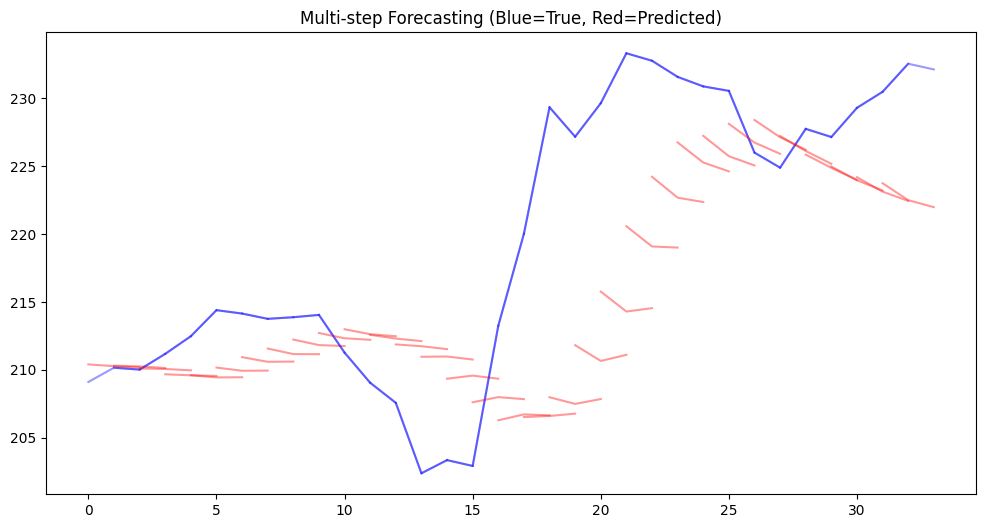

In [9]:
# ====================================
# 6. Plot
# ====================================
plt.figure(figsize=(12,6))

# Plot last 50 test samples
n = len(y_test_rescaled) # Set n to the number of available test samples
for i in range(n):
    # true future
    plt.plot(range(i, i+future_steps), y_test_rescaled[i], color="blue", alpha=0.4)
    # predicted future
    plt.plot(range(i, i+future_steps), y_pred_rescaled[i], color="red", alpha=0.4)

plt.title("Multi-step Forecasting (Blue=True, Red=Predicted)")
plt.show()

Now lets make the code smarter by using more than just closing prices.

In [10]:
import pandas as pd
import numpy as np

# Assume "data" already loaded
df = data.copy()

# 1. Daily returns
df["Return"] = df["Close"].pct_change()

# 2. Moving averages
df["MA_5"] = df["Close"].rolling(window=5).mean()
df["MA_20"] = df["Close"].rolling(window=20).mean()

# 3. Volatility (rolling std of returns)
df["Volatility"] = df["Return"].rolling(window=10).std()

# Drop NaNs from rolling calculations
df = df.dropna().reset_index(drop=True)

# ==========================
# Normalize features
# ==========================
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[["Close","Return","MA_5","MA_20","Volatility"]])

# Build sequences again
past_steps = 10
future_steps = 3

X, y = [], []
for i in range(len(scaled) - past_steps - future_steps + 1):
    X.append(scaled[i : i + past_steps])
    y.append(scaled[i + past_steps : i + past_steps + future_steps, 0])
    # <-- predict Close only (index 0)

X = np.array(X)
y = np.array(y)

print("Shape of X:", X.shape)  # (samples, timesteps, features)
print("Shape of y:", y.shape)  # (samples, future_steps)


Shape of X: (134, 10, 5)
Shape of y: (134, 3)
